Tasks:
 - read Esri Shapefile file metadata
 - read projection
     - discuss projection properties if projection is suitable for area calculation
 - show data overview based on attribute value
 - reclassify data
     - by size -> reclassify data using one parameter
     - view projection setting effect on area value
     - by size and forest type -> reclassify using multiple parameters
 - show example of pysal library usage


In [20]:
# import libraries and define data source

import fiona
from osgeo import ogr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# define data source path

esri_shapefile_clc_data_file = "clc_data.shp"

In [22]:

# print layers present in datasource and select layer as data source

layers = fiona.listlayers(esri_shapefile_clc_data_file)
print(layers)
corrine_data_layer = layers[0]

['clc_data']


In [23]:
# read file with geopandas

data = gpd.read_file(esri_shapefile_clc_data_file, driver='ESRI Shapefile', layer=corrine_data_layer)

In [24]:
# display first 3 rows of geopandas dataframe

data.head(3)

,OBJECTID,code_12,ID,Remark,Area_Ha,Shape_Leng,Shape_Area,geometry
0,1131203.0,231,EU-1131212,None,170.777228,9282.554815,1.707772e+06,"POLYGON ((4630672.26 2583252.300000001, 463058..."
1,1125046.0,112,EU-1125055,None,26.433972,2638.687709,2.643397e+05,"POLYGON ((4663266.380000001 2577258.449999999,..."
2,1075774.0,243,EU-1075783,None,105.265476,5784.879310,1.052655e+06,"POLYGON ((4641085.050000001 2563798.880000001,..."


In [25]:
# get projection data with geopandas

from fiona.crs import to_string
crs_gpd = data.crs
print(crs_gpd)
print(to_string(crs_gpd))

{'init': 'epsg:3035'}
+init=epsg:3035


In [26]:
# spatial reference system 
# Get spatial reference system from layer and layer geometry data

shape_file_driver = ogr.GetDriverByName('ESRI Shapefile')
shapefile_data_source = shape_file_driver.Open(esri_shapefile_clc_data_file)

# from layer data
layer = shapefile_data_source.GetLayer()
spatialRef = layer.GetSpatialRef()
print("Spatial reference system from layer")
print(spatialRef)
print("\n")
# from geometry data
print("Spatial reference system from layer geometry data")
feature = layer.GetNextFeature()
geom = feature.GetGeometryRef()
spatialRef = geom.GetSpatialReference()
print(spatialRef)

Spatial reference system from layer
PROJCS["ETRS89 / LAEA Europe",
    GEOGCS["ETRS89",
        DATUM["European_Terrestrial_Reference_System_1989",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6258"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4258"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",52],
    PARAMETER["longitude_of_center",10],
    PARAMETER["false_easting",4321000],
    PARAMETER["false_northing",3210000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","3035"]]


Spatial reference system from layer geometry data
PROJCS["ETRS89 / LAEA Europe",
    GEOGCS["ETRS89",
        DATUM["European_Terrestrial_Reference_System_1989",
            SPHEROID["GRS 1980",637

Lambert Azimuthal Equal Area:
- is a particular mapping from a sphere to a disk (that is, a region bounded by a circle). It accurately represents area in all regions of the sphere, but it does not accurately represent angles.

Web Mercator Projection:
- use a conformal projection that preserves direction and the shape of data but distorts distance and area, worst distortion is in the north-south direction, displays whole world -> large distortion

Gauß-Krüger Projection:
- use a conformal projection that preserves direction and the shape of data but distorts distance and area, displays word by dividing world to many zones -> small distortion


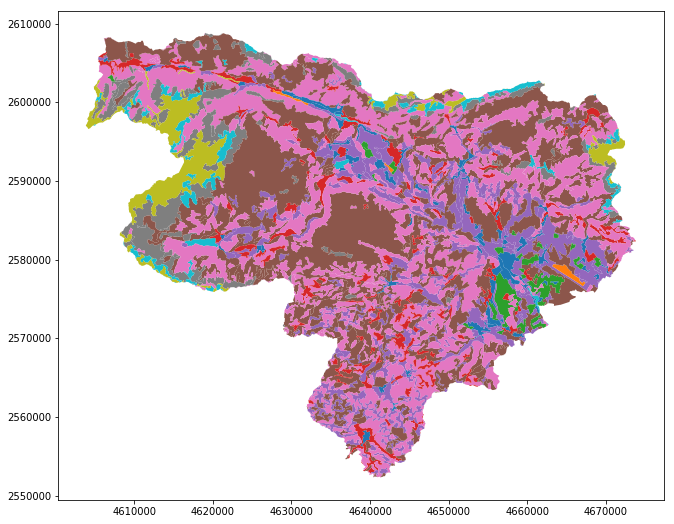

In [28]:
# display data
# use only 'code_12' and 'geometry' data for plot rendering

columns = ['code_12', 'geometry']

# set matplotlib generic plot parameters

plt.rcParams["figure.figsize"] = [16,9]

# plot data using geopandas dataframe.plot function

data.plot(column ='code_12', linewidth=0.005)

In [29]:
# read lookup table for landuse data

landuse_lookup_table = pd.read_csv("clc12_Version_18_5a.gdb/Legend/clc_legend.csv", ";")

# print first 3 rows of landuse dataframe

landuse_lookup_table.head(3)

,GRID_CODE,CLC_CODE,LABEL3,RGB
0,1,111,Continuous urban fabric,230-000-077
1,2,112,Discontinuous urban fabric,255-000-000
2,3,121,Industrial or commercial units,204-077-242


In [30]:
# append lookup table to table with geomery data

# make sure that columns - keys for join are of same type

data['code_12'] = data['code_12'].apply(int)
landuse_lookup_table['CLC_CODE'] = landuse_lookup_table['CLC_CODE'].apply(int)

# join data

data = data.merge(landuse_lookup_table, left_on='code_12', right_on='CLC_CODE', how='left')
data.head(3)

,OBJECTID,code_12,ID,Remark,Area_Ha,Shape_Leng,Shape_Area,geometry,GRID_CODE,CLC_CODE,LABEL3,RGB
0,1131203.0,231,EU-1131212,None,170.777228,9282.554815,1.707772e+06,"POLYGON ((4630672.26 2583252.300000001, 463058...",18,231,Pastures,230-230-077
1,1125046.0,112,EU-1125055,None,26.433972,2638.687709,2.643397e+05,"POLYGON ((4663266.380000001 2577258.449999999,...",2,112,Discontinuous urban fabric,255-000-000
2,1075774.0,243,EU-1075783,None,105.265476,5784.879310,1.052655e+06,"POLYGON ((4641085.050000001 2563798.880000001,...",21,243,"Land principally occupied by agriculture, with...",230-204-077


In [31]:
# get unique land usage values

unique_land_usage_values = list(data['LABEL3'].unique())

# generation of list with forest land usage values

forest_land_usage_values = [val for val in unique_land_usage_values if 'forest' in val]
print(forest_land_usage_values)

# Broad-leaved forest - listnati gozd
# Mixed forest - mešani gozd
# Coniferous forest - iglasti gozd

['Broad-leaved forest', 'Mixed forest', 'Coniferous forest']


In [32]:
# get only forest data from data

leaved_forest = data.loc[data['LABEL3'] == 'Broad-leaved forest'] # listnati gozd
mixed_forest = data.loc[data['LABEL3'] == 'Mixed forest'] # mešani gozd
coniferus_forest = data.loc[data['LABEL3'] == 'Coniferous forest'] # iglasti gozd

# make on data frame for forest data
forest_data = pd.concat([leaved_forest, mixed_forest, coniferus_forest])

In [33]:
# area in ha

forest_data['area_lambert'] = data.geometry.area/10**4

forest_data.head(5)

,OBJECTID,code_12,ID,Remark,Area_Ha,Shape_Leng,Shape_Area,geometry,GRID_CODE,CLC_CODE,LABEL3,RGB,area_lambert
3,1067562.0,311,EU-1067571,None,56.003683,6030.067761,560036.827349,"POLYGON ((4643932.59 2556996.470000001, 464388...",23,311,Broad-leaved forest,128-255-000,56.003683
6,1141474.0,311,EU-1141483,None,49.015728,3591.082932,490157.278549,"POLYGON ((4629775.07 2578795.57, 4629797.34 25...",23,311,Broad-leaved forest,128-255-000,49.015728
8,1141477.0,311,EU-1141486,None,44.655099,3363.051543,446550.995000,"POLYGON ((4650256.369999999 2578293.960000001,...",23,311,Broad-leaved forest,128-255-000,44.655099
10,1141479.0,311,EU-1141488,None,64.931274,5550.401093,649312.740299,"POLYGON ((4625432.5 2577535.310000001, 4625414...",23,311,Broad-leaved forest,128-255-000,64.931274
14,1141483.0,311,EU-1141492,None,80.865575,5734.887283,808655.750950,"POLYGON ((4619417.73 2578792.310000001, 461943...",23,311,Broad-leaved forest,128-255-000,80.865575


In [35]:
# transform forest data to Web Mercator Projection

forest_data_wm = forest_data.copy()
forest_data_wm = forest_data_wm.to_crs({'init': 'epsg:3857'})

# calculate distorted area for polygon on 46 degrees latitude
import math
print(math.pow(1/math.cos(math.radians(46)), 2) * 56.003683)

# area in ha

forest_data_wm['area_wm'] = forest_data_wm.geometry.area/10**4
forest_data_wm.head(5)

# web mercator distorsion
#1/cos(fi)

116.05772208935728


,OBJECTID,code_12,ID,Remark,Area_Ha,Shape_Leng,Shape_Area,geometry,GRID_CODE,CLC_CODE,LABEL3,RGB,area_lambert,area_wm
3,1067562.0,311,EU-1067571,None,56.003683,6030.067761,560036.827349,"POLYGON ((1577343.748022256 5787477.788128244,...",23,311,Broad-leaved forest,128-255-000,56.003683,116.210237
6,1141474.0,311,EU-1141483,None,49.015728,3591.082932,490157.278549,"POLYGON ((1558647.705076776 5820097.069361451,...",23,311,Broad-leaved forest,128-255-000,49.015728,102.449003
8,1141477.0,311,EU-1141486,None,44.655099,3363.051543,446550.995000,"POLYGON ((1588100.396315693 5817721.233496949,...",23,311,Broad-leaved forest,128-255-000,44.655099,93.304146
10,1141479.0,311,EU-1141488,None,64.931274,5550.401093,649312.740299,"POLYGON ((1552300.590235839 5818609.288485087,...",23,311,Broad-leaved forest,128-255-000,64.931274,135.716403
14,1141483.0,311,EU-1141492,None,80.865575,5734.887283,808655.750950,"POLYGON ((1543729.370745817 5820886.694174135,...",23,311,Broad-leaved forest,128-255-000,80.865575,169.047475


In [36]:
# transform forest data to 3912 - Slovenia D48 Projection

forest_data_d48 = forest_data.copy()
forest_data_d48 = forest_data_d48.to_crs({'init': 'epsg:3912'})
forest_data_d48['area_d48'] = forest_data_d48.geometry.area/10**4

# area in ha

forest_data_d48.head(5)

,OBJECTID,code_12,ID,Remark,Area_Ha,Shape_Leng,Shape_Area,geometry,GRID_CODE,CLC_CODE,LABEL3,RGB,area_lambert,area_d48
3,1067562.0,311,EU-1067571,None,56.003683,6030.067761,560036.827349,"POLYGON ((436098.2873621507 100372.4473408666,...",23,311,Broad-leaved forest,128-255-000,56.003683,55.999442
6,1141474.0,311,EU-1141483,None,49.015728,3591.082932,490157.278549,"POLYGON ((423383.5947467986 123085.4340612004,...",23,311,Broad-leaved forest,128-255-000,49.015728,49.014037
8,1141477.0,311,EU-1141486,None,44.655099,3363.051543,446550.995000,"POLYGON ((443769.9930161881 121221.9891300155,...",23,311,Broad-leaved forest,128-255-000,44.655099,44.650565
10,1141479.0,311,EU-1141488,None,64.931274,5550.401093,649312.740299,"POLYGON ((418973.3514961803 122115.0186698139,...",23,311,Broad-leaved forest,128-255-000,64.931274,64.930006
14,1141483.0,311,EU-1141492,None,80.865575,5734.887283,808655.750950,"POLYGON ((413057.6281114304 123769.4363684105,...",23,311,Broad-leaved forest,128-255-000,80.865575,80.866272


In [15]:
# forest classification with one variable (forest area value) -> forests that are bigger than 3000 hectares

forest_data['thirty_ha'] = None
def classifyByArea(row, source_column, output_column, threshold_value):
    if row[source_column] > threshold_value:
        row[output_column] = 1
    else:
        row[output_column] = 0
    return row

forest_data = forest_data.apply(classifyByArea, source_column = 'area_lambert', 
                                output_column = 'thirty_ha', threshold_value = 3000, axis = 1)

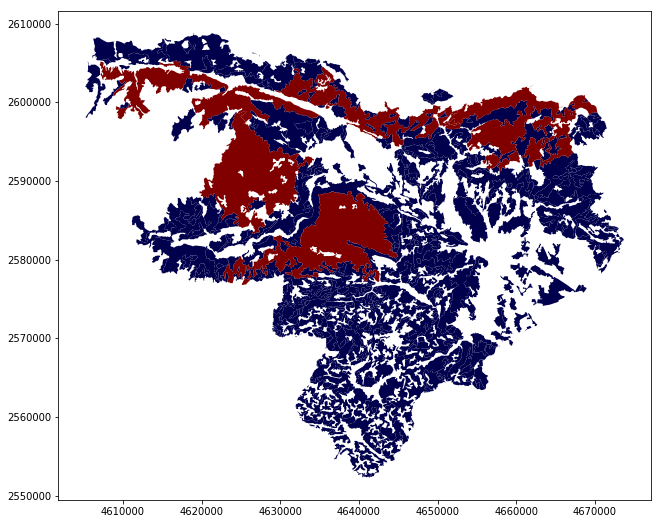

In [16]:
forest_data.plot(column ='thirty_ha', linewidth=0.005, cmap="seismic")

In [37]:
# forest classification with multiple variables (forest area value, forest type value) -> 
# forests that are bigger than 3000 hectares and coniferous

forest_data['thirty_ha_coniferous'] = None
def classifyByAreaAndType(row, src_col_one, src_col_two, threshold_one, threshold_two, output_column):
    if (row[src_col_two] == threshold_two and row[src_col_one] > threshold_one):
        row[output_column] = 1
    else:
        row[output_column] = 0
    return row

forest_data = forest_data.apply(classifyByAreaAndType, src_col_one='area_lambert', 
                                src_col_two='LABEL3', threshold_one = 3000, threshold_two ='Coniferous forest', output_column="thirty_ha_coniferous", axis=1)

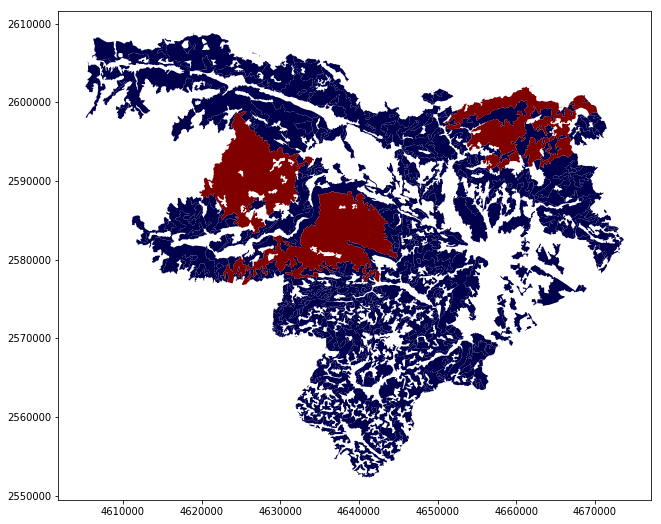

In [38]:
forest_data.plot(column ='thirty_ha_coniferous', linewidth=0.005, cmap="seismic")

Python library with many map classification methods is pysal:

https://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html


Natural Breaks classification

Classes are based on natural groupings inherent in the data. Break points are identified by picking the
class breaks that best group similar values and maximize the differences between classes. The features are
divided into classes whose boundaries are set where there are relatively big jumps in the data values. 

Good when mapping values that are not evenly distributed on histogram 

/Users/klemen/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


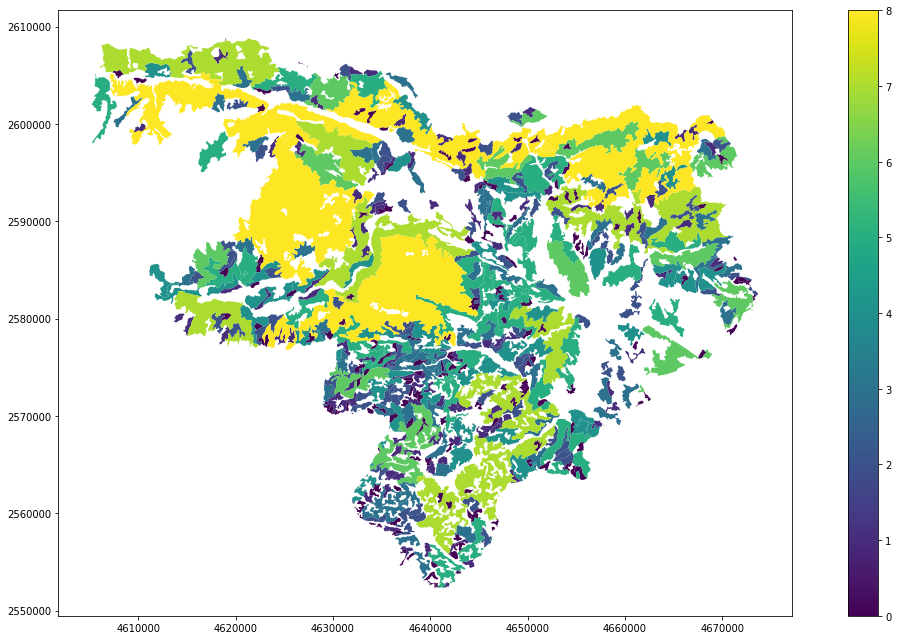

In [19]:
# Natural Breaks example classification

import pysal as ps

number_of_classes = 9
pysal_classifier = ps.Natural_Breaks.make(k=number_of_classes)

classifications = forest_data[['area_lambert']].apply(pysal_classifier)

classifications.columns = ['natural_breaks']

forest_data = forest_data.join(classifications)

forest_data.plot(column="natural_breaks", linewidth=0, legend=True)

plt.tight_layout()